# Number of trips per day

Hypothesis: The temperature on a given day affects the number of trips taken that day

Observations based on exploration
1. 99%+ of trips are made by subscribers
2. High number of commuters (high volume of trips during commute time) 
3. Strong relationship b/w temperature and number of trip taken (+ve relationship 0 - 80 & -ve relationship 80+)
4. Not a significant relationship b/w temperature on trip length

This notebook aims to focus on some useful finding that will help data scientists who may want to study the effect of different variables on number of trips to understand the specific effect of temperature on number of trips. It could be useful to remove this effect to normalize the data. 

## Approach one: Regression models 
Let us assume that there is a model that can correctly predict the variable number_of_trips_on_given_day

\begin{align}
\ y_i &= F_t(t_i) + F_u( \bar{x_i} ) \\
\end{align}

where $\ y_i$ is the predicted number of trips on a given day given the two week models: the model $\ F_t$ which uses the representative temperature $\ t_i$ for the day $\ i$ and $\ F_u$ is the model that predicts the number of trips per day using a combination of other input variables.

The goal is to build the model $\ F_t$ so that we can buid a model with other independent variables to predict the residual value.

One approach to model this is as follows:
1. Group by date so you can get some reprentative temperature (t) for each day that there was a trip and the number of trips (y)
2. Fit a model to y on t.
3. Calculate some metrics that tell you the goodness of fit

In [37]:
# read data
import pandas
READ_PATH = '/Users/calvinperumalla/cbs_data/data_100000_pts.csv'
df = pandas.read_csv(READ_PATH)

In [38]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'year', 'month', 'week', 'day', 'hour',
       'usertype', 'gender', 'starttime', 'stoptime', 'tripduration',
       'temperature', 'events', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end'],
      dtype='object')

### Get per day stats

In [39]:
df['date'] = pandas.to_datetime(df['starttime']).dt.date

In [40]:
import numpy
df_date = df.groupby('date').aggregate({'trip_id': pandas.Series.nunique, 'temperature':pandas.Series.mean})

Text(0, 0.5, '#trips/day')

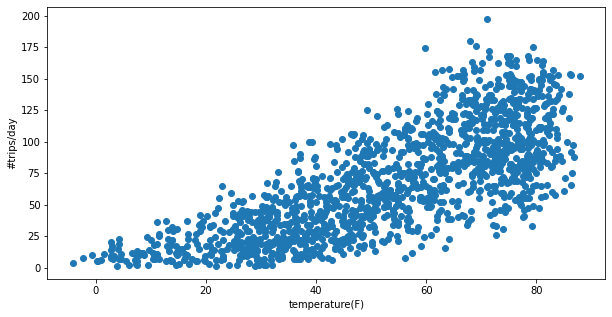

In [44]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(df_date['temperature'],df_date['trip_id'])
ax.set_xlabel('temperature(F)')
ax.set_ylabel('#trips/day')

### trying the model

$y = ax + b $ 
and 
$y = ax^2 + b $

In [101]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X = numpy.array(df_date['temperature']).reshape((-1, 1))
y = df_date['trip_id']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3)

In [105]:
linear_regressaurus = linear_model.LinearRegression()
linear_regressaurus.fit(X_train, y_train)
y_pred = linear_regressaurus.predict(X_test)

In [152]:
#X_sq_train, X_sq_test, y_sq_train, y_sq_test  = train_test_split(X, y, test_size=0.3)
X_sq_train = X_train ** 2
X_sq_test = (0.2 * X_test) ** 2
y_sq_train = y_train
y_sq_test = y_test

In [143]:
nonlinear_regressaurus = linear_model.LinearRegression()
nonlinear_regressaurus.fit(X_sq_train, y_sq_train)
y_pred_model_2 = nonlinear_regressaurus.predict(X_sq_test)

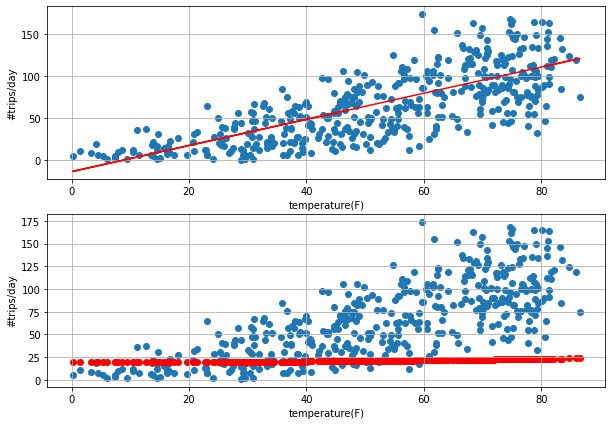

In [147]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, figsize=(10, 7))
ax[0].scatter(X_test, y_test)
ax[0].plot(X_test, y_pred, color='r')

ax[1].scatter(X_test, y_sq_test)
ax[1].scatter(X_test, y_pred_model_2, color='r')

ax[0].set_xlabel('temperature(F)')
ax[0].set_ylabel('#trips/day')

ax[1].set_xlabel('temperature(F)')
ax[1].set_ylabel('#trips/day')

ax[0].grid()
ax[1].grid()

In [157]:
from sklearn.metrics import r2_score
r2_score(y_pred, y_test)

0.25776820015694124

In [153]:
r2_score(y_pred_model_2, y_sq_test)

-2321.0695074731116

A simple linear model performs better than the non linear model.

The hard question to answer is: how to verify that this model is able to capture predict variable (#trips/day) as best as possible 

### Caveats:
1. This approach does not take into account the days where there are no trips. This becomes especially important in modeling extreme temperatures. For example we only see few days where the mean temperature is above 90 degrees but the number of rides are high. Are these outliers to a distribution of days with 90F mean temp that largely has zeros? 

Possible solution: An interesting approach would be do the above analysis on a different dataset. To get this data set we would look at all days between a given time period in our data set (For example jan 2014- dec 2018) and count the number of trips taken, then join a temperature database with the mean temperatures for every single day in the time period and add 0 for the days we do not have trips. This is assuming that we have data for every trip taken in the time period

## Approach 2: Normal Approximation
What we really are interested in is how the temperature affects the probability that a trip is taken or not.

Lets define it!
It's a Bernoulli distribution of two values: {a bike is rented, a bike is not rented} conditioned upon the temperature t. 

\begin{align}
\ P(v = a\ bike\ is\ rented| T=t) = p_t
\end{align}

Consider the variable X at temperature t

\begin{align}
\ X_t = \sum_{i=1}^N v_i^t \\
where\ v_i\ is\ a\ realization\ of\ the\ variable\ v
\end{align}

X is the number bikes rented a.k.a trips taken when temperature was t.
We know that X approximates to a normal distribution with a mean of  $\ Np_t $

If we can approximate N then we can have a decent shot at evaluating p_t

In a typical setting, N is the number of times you ran the Bernouli trial. For example how many times you flip a coin.
In this setting however, It is hard to estimate N because hard to say how many people did not want to ride bikes when it was a certain temperature. 

How do we solve this?
One approach is to think of the maximum number of trips for a given temp in the data set as N. Normalizing our probability to the most popular temperature to ride bikes

A debatable but interesting approach would be to think of every available bike in the dock as a opportunity or a question to the chicago public if they would like to bike. For every trip taken we have a variable called dcapacity, which shows the number of bikes in the docks. So for every trip taken there 'dcapacity' denials to take trips. Adding this two values up across our data set can give us N. 

## Approach 3: Bayes law
According to Bayes rule:
\begin{align}
\ P(v|T=t) &= \frac{P(T=t|v)P(T=t)}{P(v)}
\end{align}

we can calculate $\ P(T=t|v)$ from the data by 
we can calculate $\ P(P(T=t))$ by looking at a weather database
we can calculate $\ P(v)$ This is tricker to model but we can use some of the assumptions above to get the value for $\ p_0$ which is the probability that the there will be a trip

This value will however be common for all temperatures so if we want to just compare probabilities we can avoid this step